D:\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
D:\anaconda\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
D:\anaconda\Lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
D:\anaconda\Lib\site-packages\cartopy\mpl\geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'projection'
  result = super().contourf(*args, **kwargs)


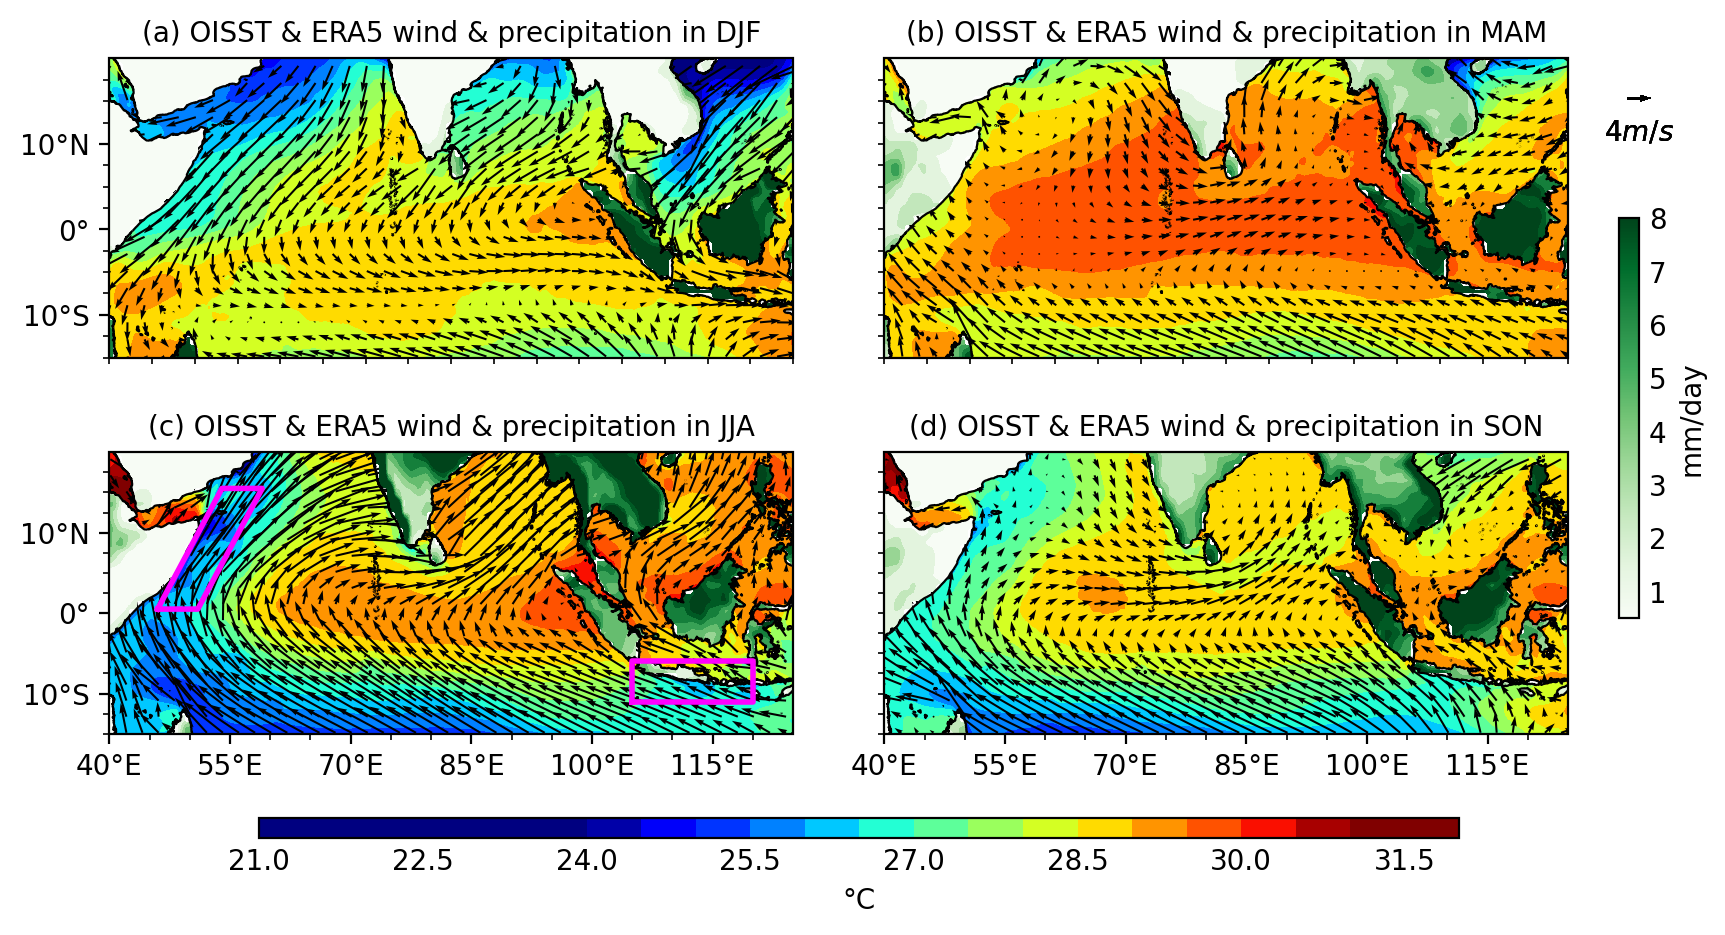

In [1]:
import numpy as np
import xarray as xr
from scipy.interpolate import interp1d
import pandas as pd
import function
import matplotlib.pyplot as plt
from scipy.integrate import quad
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from matplotlib.colors import ListedColormap
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib as mpl
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
import colormaps as cmaps 
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import copy
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#file="E:\\data\\era5\\sst_season_avg_0N20N40E80E.nc";ds0 = xr.open_dataset(file)
#ds= list(ds0.data_vars.values())[0];sst=ds.rename({'lat': 'latitude','lon':'longitude'})
file="E:\data\oisst\sst_mon_ltm_1991-2020.nc";ds=xr.open_dataset(file);#"E:\data\oisst\sst_mon_ltm_1991-2020.nc"
ds=ds.sst.rename({'lat': 'latitude','lon': 'longitude'}).sel(latitude=slice(-15,20),longitude=slice(40,125))
sst=ds.groupby('time.season').mean('time').rename({'season': 'time'})

file="E:\data\era5\ERA5_IO_u_wind&v_wind&pre.nc";ds = xr.open_dataset(file);
#ds=ds0.reindex(latitude=list(reversed(ds0.latitude))).groupby('time.season').mean('time').rename({'season': 'time'})
u=ds.u10.interp(latitude=sst.latitude.data,longitude=sst.longitude);
v=ds.v10.interp(latitude=sst.latitude.data,longitude=sst.longitude);

file="E:\data\GPCP\GPCP_1982-2024_1_global_monitor.nc";#这组数据'2021-05-01T00:00:00.000000000'之后全是inf，要去掉
ds = xr.open_dataset(file);ds=ds.rename({'lat': 'latitude','lon':'longitude'});
ds=ds.sel(time=slice('1982-01-01T00:00:00.000000000','2021-04-30T00:00:00.000000000'))
ds=ds.reindex(latitude=list(reversed(ds.latitude)))#.groupby('time.season').mean('time').rename({'season': 'time'})
pre=ds.precip.interp(latitude=sst.latitude.data,longitude=sst.longitude);

'''fig1'''

#land只要陆地降雨
ds = sst[0,:,:]
ds = ds.fillna(0)# 将原有的 NaN 转换为零
a=ds.where(ds == 0, np.nan)# 将非零值转换为 NaN

mlt_seasonal_means =sst
mlu_seasonal_means = u.groupby('time.season').mean('time').rename({'season': 'time'})
mlv_seasonal_means = v.groupby('time.season').mean('time').rename({'season': 'time'})
pre=(pre/30+a*0).groupby('time.season').mean('time').rename({'season': 'time'})#mm/day为单位

key=['DJF','MAM','JJA' ,'SON']
df=mlt_seasonal_means
mlt_seasonal_means=df.fillna(mlt_seasonal_means.mean())+mlt_seasonal_means.data[0,:,:]*0
fig = plt.figure(figsize=(10, 5),dpi=200)
gs = fig.add_gridspec(ncols=3, nrows=3, width_ratios=[10, 10, 0.001],height_ratios=[10, 10, 0.001])

# 创建一个 2x2 的子图网格，并为每个子图绘制数据
axs = np.empty((2, 2), dtype=object)
# 共享的颜色条范围
vmin = 24;vmax = 31
text=['a','b','c','d'];j=0
for i in key:
    row = j // 2 ; col = j % 2
    #ax=fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree())
    axs[row , col] = fig.add_subplot(gs[row , col], projection=ccrs.PlateCarree())
    cf = axs[row , col].contourf(mlt_seasonal_means.longitude,mlt_seasonal_means.latitude,mlt_seasonal_means.sel(time=i),
                                 cmap='jet', vmin=vmin, vmax=vmax,levels=np.arange(21 ,32.5, 0.5), projection=ccrs.PlateCarree())
    
    x,y = np.meshgrid(mlu_seasonal_means.longitude.data , mlu_seasonal_means.latitude.data)
    mlu = mlu_seasonal_means.sel(time=i);mlv = mlv_seasonal_means.sel(time=i)
    '''quiver矢量y值决定颜色'''
    lat_va=8;lon_va=8
    cb = axs[row , col].quiver(x[::lon_va,::lat_va],y[::lon_va,::lat_va],mlu[::lon_va,::lat_va],mlv[::lon_va,::lat_va],
                               width=0.003,scale=120,angles='xy',zorder=1)#, pivot='mid'
    qk = axs[row , col].quiverkey(cb, 0.89, 0.82, 4, r'$4m/s$', labelpos='S', coordinates='figure')#S代表m/s在箭头下方
    axs[row , col].set_title(f'({text[j]}) OISST & ERA5 wind & precipitation in {i}',fontsize=10);j=j+1
    # 设置地图的地理范围
    # 定义绘图区域的经纬度范围
    min_lon, max_lon = 40, 120
    min_lat, max_lat = -15, 20
    axs[row , col].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    # 添加地理特征（海岸线、国界等）
    coastline = NaturalEarthFeature(category='physical', name='coastline', scale='10m',
                                    facecolor='none')
    #borders = NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='10m',
                                  #facecolor='none')
    #land = NaturalEarthFeature(category='physical', name='land', scale='10m',
                               #facecolor='lightgray')
    axs[row , col].add_feature(coastline, edgecolor='black',linewidth=0.8,)
    #ax.add_feature(borders, linestyle=':', linewidth=0.5, edgecolor='black')
    #ax.add_feature(land)
    prec=axs[row , col].contourf(pre.longitude,pre.latitude,pre.sel(time=i),cmap='Greens',#cmaps.algae,#cmaps.cet_l_wcmr,#cmaps.cmp_haxby_r,
                                 vmax=8,vmin=0.5,projection=ccrs.PlateCarree(),levels=np.arange(0,34,1)) 
    #plt.clabel(prec, inline=True, fontsize=9, fmt='%1.1f')
    axs[row,col].minorticks_on()# 启用次刻度
    axs[row,col].set_yticks(np.arange(-15, 20, 2.5), minor=True);
    axs[row,col].set_xticks(np.arange(40, 125, 5), minor=True)#设置次刻度的位置

m = Basemap(projection='cyl', resolution='l',
            llcrnrlon=40, llcrnrlat=-15,
            urcrnrlon=125, urcrnrlat=20, ax=axs[1,0])#选择展示的图片
x, y, width, height, skew = 46, 0.5, 5, 15, 8
#Somali 创建平行四边形的四个顶点坐标
points = [(x, y),
          (x + width, y),
          (x + width + skew, y + height),
          (x + skew, y + height),
          (x, y)]
# 将经纬度坐标转换成地图上的 x 和 y 坐标
xpts, ypts = m(*zip(*points))
# 使用 plot 方法绘制多边形
m.plot(xpts, ypts, color='magenta', linewidth=2)#fuchsia

x, y, width, height, skew = 105, -11, 15, 5, 0
# Java
points = [(x, y),
          (x + width, y),
          (x + width + skew, y + height),
          (x + skew, y + height),
          (x, y)]
# 将经纬度坐标转换成地图上的 x 和 y 坐标
xpts, ypts = m(*zip(*points))
# 使用 plot 方法绘制多边形
m.plot(xpts, ypts, color='magenta', linewidth=2)#fuchsia


axs[0,0].set_yticks(np.arange(-10, 20, 10));axs[1,0].set_yticks(np.arange(-10, 20, 10))
axs[0,1].set_yticks([]);axs[1,1].set_yticks([])
axs[0,1].set_xticks([]);axs[0,0].set_xticks([])
axs[0,0].set_ylim(-15 , 20);axs[1,0].set_ylim(-15 , 20)
#axs[0,0].set_ylabel('latitude',fontsize=9);axs[1,0].set_ylabel('latitude',fontsize=9)
axs[0,0].yaxis.set_major_formatter(LatitudeFormatter());axs[1,0].yaxis.set_major_formatter(LatitudeFormatter())

axs[1,1].set_xticks(np.arange(40,121, 15));axs[1,0].set_xticks(np.arange(40, 121, 15))
axs[1,1].set_xlim(40 , 125);axs[1,0].set_xlim(40 , 125)
axs[1,1].set_xlabel(' ',fontsize=9);axs[1,0].set_xlabel(' ',fontsize=9)
axs[1,1].xaxis.set_major_formatter(LongitudeFormatter());axs[1,0].xaxis.set_major_formatter(LongitudeFormatter())

position=fig.add_axes([0.88, 0.3, 0.01, 0.4])#位置[左,下,右,上]
#cb=fig.colorbar(prec,cax=position,orientation='vertical',label='mm/day',extend='both',
                #ticks=[ 0, 1,2,3,4,5, 6,7, 8, 32])#方向

cmap1 = copy.copy('Greens')
norm1 = mcolors.Normalize(vmin=0.5, vmax=8)
im1 = cm.ScalarMappable(norm=norm1, cmap=cmap1)
cbar1 = fig.colorbar(
    im1, cax=position, orientation='vertical',
    ticks=[ 0, 1,2,3,4,5, 6,7, 8],
    label='mm/day',
    )
cbar1.ax.tick_params(length=0)

position=fig.add_axes([0.2, 0.08, 0.6, 0.02])#位置[左,下,右,上]
cb=fig.colorbar(cf,cax=position,orientation='horizontal',label='°C',)#方向
cb.ax.tick_params(length=0)
#plt.savefig('G:\\fig\\temp_salt\\sst+wind彩色_oras共享坐标轴')
plt.subplots_adjust()
plt.show()

D:\anaconda\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
D:\anaconda\Lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


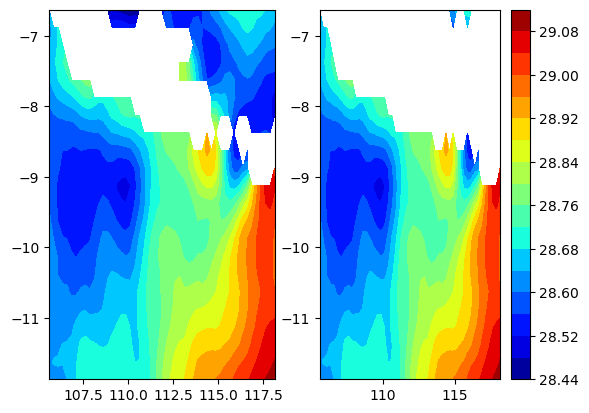

In [2]:
'''Somali mask'''
mask=function.make_mask3D(sst,5/(sst.latitude.data[1]-sst.latitude.data[0]),sst)*0
'''Java mask'''
import numpy as np
import xarray as xr
from scipy.interpolate import interp1d
import pandas as pd
import function
import matplotlib.pyplot as plt

def matching_lat(lat_value,data): # 文件编码方式[lats,lons]，data:需要输入xr.open_dataset()
    '''经纬度与格点位置匹配,输入经纬度,nc数据,输出所在格点位置对应索引值 lon_idx：经度 lat_idx：纬度'''
    lats = data['latitude'].values# 获取纬度的坐标值
    lat_idx = np.abs(lats - lat_value).argmin()# 获取经纬度坐标的索引值
    return lat_idx
def matching_lon(lon_value,data): 
    lons = data['longitude'].values
    lon_idx = np.abs(lons - lon_value).argmin()
    return lon_idx
def make_mask3D(da,edge):
    data=edge.sel(time=edge.time[1])*0+da.sel(time=da.time[1])
    plt.subplot(1,2,1)
    plt.contourf(da.longitude,da.latitude,data.data,levels=20,cmap='jet')
    daily_mask=data.data+data*0#daily_mask代表只取离岸5°的数据
    for lat in range(0,len(data.latitude)):
        for lon in range(0,len(data.longitude)):
            if np.isnan(daily_mask[lat,lon]):
                daily_mask[lat:-1,lon]=np.nan
    plt.subplot(1,2,2)
    plt.contourf(da.longitude,da.latitude,da.data[1,:,:]+daily_mask*0,[250,300],levels=20,cmap='jet')
    plt.colorbar()
    return daily_mask*0
file="E:\data\oisst\sst_mon_ltm_1991-2020.nc";ds=xr.open_dataset(file);#"E:\data\oisst\sst_mon_ltm_1991-2020.nc"
ds=ds.sst.rename({'lat': 'latitude','lon': 'longitude'}).sel(latitude=slice(-12, -6.625),longitude=slice(105.5,118.125))
java_sst=ds.groupby('time.month').mean('time').rename({'month': 'time'})
java_sst.loc[dict(time=slice(1,12), latitude=-8.375, longitude=114.625)]  = np.nan#去掉小岛之间的值，做colorbar
java_sst.loc[dict(time=slice(1,12), latitude=-8.375, longitude=116.125)]  = np.nan
java_mask=make_mask3D(java_sst,java_sst)
file="E:\data\era5\ERA5_IO_u_wind&v_wind&pre.nc";ds = xr.open_dataset(file);
ds=ds.sel(latitude=slice(-12, -6.625),longitude=slice(105.5,118.125))
java_u=ds.u10.interp(latitude=java_sst.latitude.data,longitude=java_sst.longitude);
java_u=java_u.groupby('time.month').mean('time').rename({'month': 'time'})
java_v=ds.v10.interp(latitude=java_sst.latitude.data,longitude=java_sst.longitude)
java_v=java_v.groupby('time.month').mean('time').rename({'month': 'time'})
#plt.contourf(java_v.longitude,java_v.latitude,java_v[0,:,:])

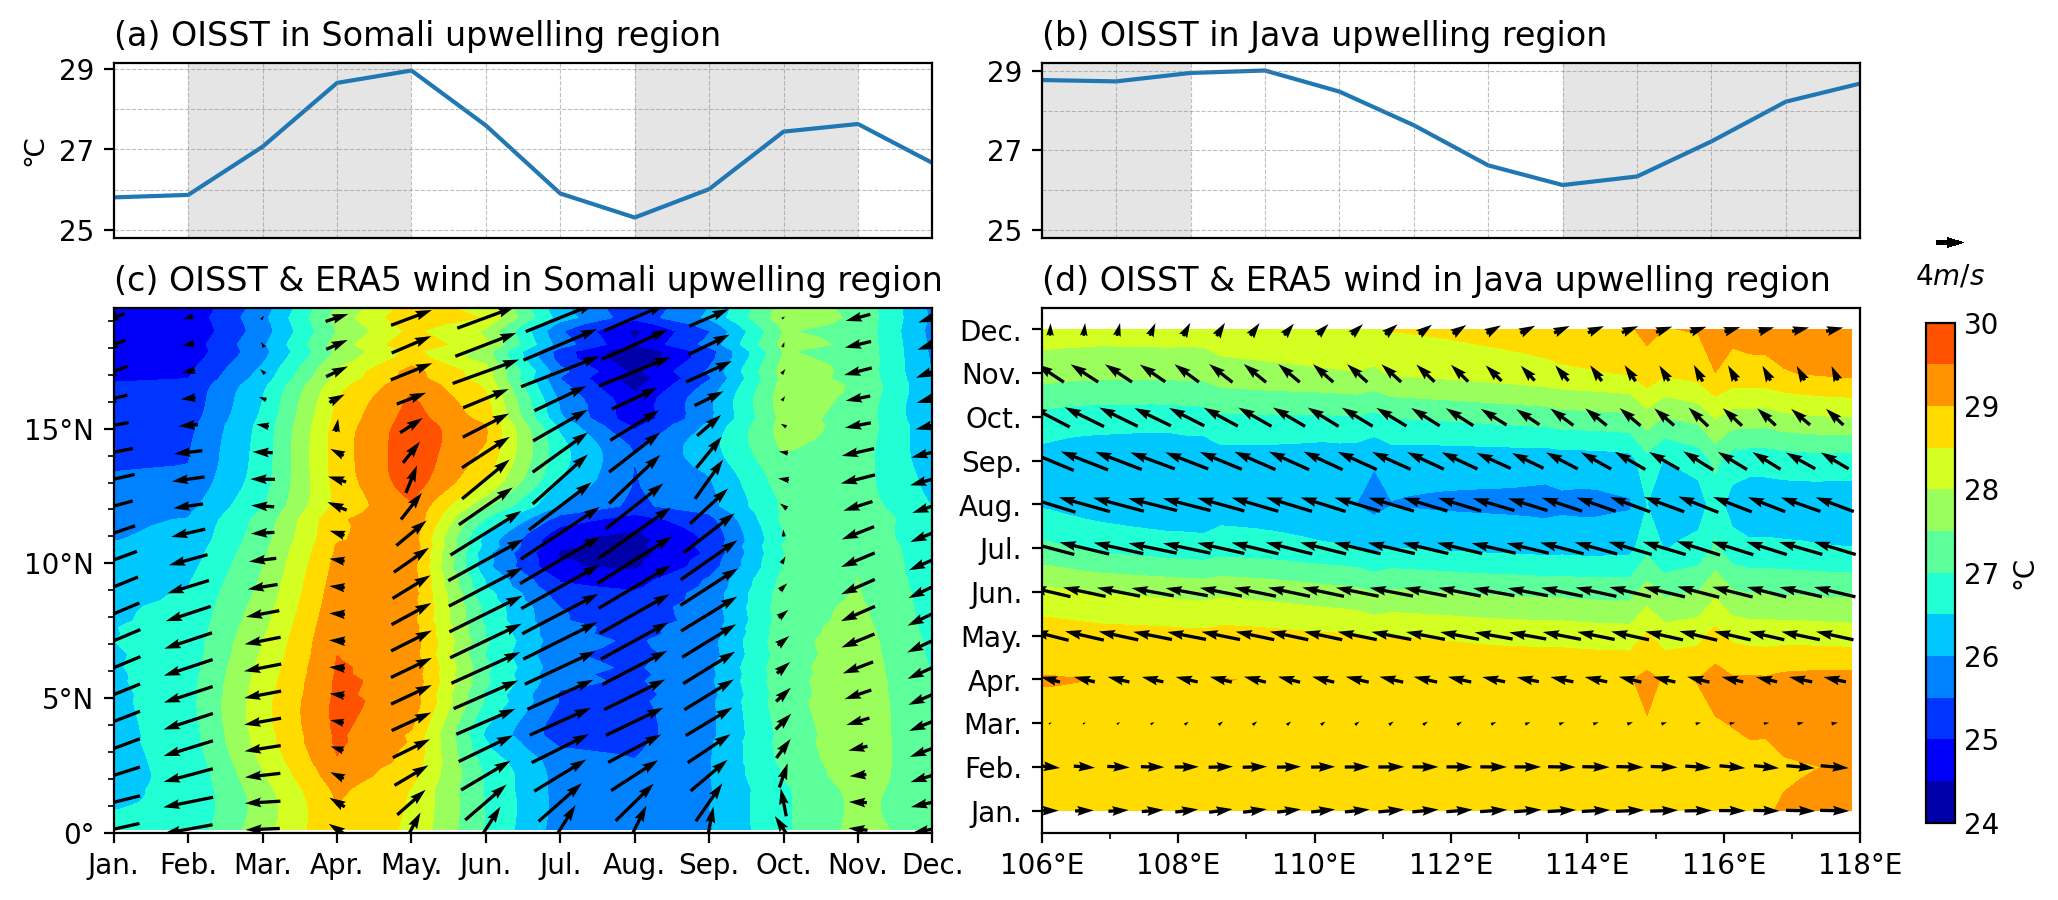

In [6]:
import matplotlib.gridspec as gridspec
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
'''fig2'''
# 创建一个图形
fig= plt.figure( figsize=(12, 5),dpi=200) #sharex=True,# sharey=True
                  #constrained_layout=True)# 使用 gridspec 来定义子图的位置和大小
gs = gridspec.GridSpec(2, 3,  height_ratios=[1, 3],width_ratios=[2, 2,0.01])
ax2=fig.add_subplot(gs[0, 0]) 
ax3=fig.add_subplot(gs[1, 1])
ax4=fig.add_subplot(gs[0, 1])  
# 第一个子图占据较大的空间
ax1= fig.add_subplot(gs[1, 0])  # 占据第一行的第一列
vmin=24;vmax=31
cf = ax1.contourf(u.time,sst.latitude[0:-1],(sst+mask).mean('longitude').T[0:-1,:],
                     cmap='jet', vmin=vmin, vmax=vmax,levels=np.arange(24 ,30.5, 0.5))
position=fig.add_axes([0.88, 0.12, 0.012, 0.5])
cb=fig.colorbar(cf,orientation='vertical',label='°C',cax=position,)#方向
cb.ax.tick_params(length=0)#colorbar无刻度线
x,y = np.meshgrid(u.time.data , sst.latitude.data)
mlu = (u+mask).mean('longitude').T;mlv = (v+mask).mean('longitude').T
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.set_ylim([0,19.5])
ax1.set_title('(c) OISST & ERA5 wind in Somali upwelling region',loc='left',)
cb = ax1.quiver(x[::4,::1],y[::4,::1],mlu[::4,::1],mlv[::4,::1],
               width=0.004,scale=120,angles='xy',zorder=1, pivot='mid')

cf = ax3.contourf(java_sst.longitude[0:-1],u.time,(java_sst+java_mask).mean('latitude')[:,0:-1],
                     cmap='jet', vmin=vmin, vmax=vmax,levels=np.arange(24 ,30.5, 0.5))
x,y = np.meshgrid( java_sst.longitude.data, u.time.data )
mlu = (java_u+java_mask).mean('latitude');mlv = (java_v+java_mask).mean('latitude')
ax3.xaxis.set_major_formatter(LongitudeFormatter())
ax3.set_xlim([106,114])
ax3.set_title('(d) OISST & ERA5 wind in Java upwelling region',loc='left',)
y_field=1;x_field=2
cb = ax3.quiver(x[::y_field,::x_field],y[::y_field,::x_field],mlu[::y_field,::x_field],mlv[::y_field,::x_field],
                width=0.004,scale=120,angles='xy',zorder=1, pivot='mid')
qk = ax3.quiverkey(cb, 0.89, 0.7, 4, r'$4m/s$', labelpos='S', coordinates='figure')

ax2.plot(u.time,(sst+mask).mean('latitude').mean('longitude'))
#ax2.plot(u.time,((u**2+v**2)**0.5+mask).mean('latitude').mean('longitude'))
ax2.axvspan(2,5, facecolor='gray', alpha=0.2);ax2.axvspan(8,11, facecolor='gray', alpha=0.2);
for xline in range(25,30):
    ax2.axhline(y=xline, color='gray', linestyle='--',lw=0.4,alpha=0.5)
for yline in range(2,13):
    ax2.axvline(x=yline, color='gray', linestyle='--',lw=0.4,alpha=0.5)

ax4.plot(u.time,(java_sst+java_mask).mean('latitude').mean('longitude'))
ax4.axvspan(8,12, facecolor='gray', alpha=0.2);ax4.axvspan(1,3, facecolor='gray', alpha=0.2);
for xline in range(25,30):
    ax4.axhline(y=xline, color='gray', linestyle='--',lw=0.4,alpha=0.5)
for yline in range(2,13):
    ax4.axvline(x=yline, color='gray', linestyle='--',lw=0.4,alpha=0.5)

ax2.set_title('(a) OISST in Somali upwelling region',loc='left')
ax4.set_title('(b) OISST in Java upwelling region',loc='left')
ax2.set_ylabel('℃')
ax2.set_xlim([1,12]);ax2.set_xticks([]);ax4.set_xlim([1,12]);ax4.set_xticks([])
ax2.set_yticks(np.arange(25, 31, 2));ax2.set_yticks([25,27,29]);ax4.set_yticks([25,27,29])
ax1.set_xlim([1,12]);ax3.set_ylim([0.5,12.5])
ax1.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12]);ax1.set_yticks([0,5,10,15]);
ax3.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12]);ax3.set_xticks([106,108,110,112,114,116,118])
ax1.set_xticklabels(['Jan.','Feb.','Mar.','Apr.','May.','Jun.','Jul.','Aug.','Sep.','Oct.','Nov.','Dec.'],)
ax3.set_yticklabels(['Jan.','Feb.','Mar.','Apr.','May.','Jun.','Jul.','Aug.','Sep.','Oct.','Nov.','Dec.'],)

ax1.minorticks_on()# 启用次刻度
ax1.set_yticks(np.arange(0, 20, 1), minor=True)  # # 设置次刻度的位置
ax1.xaxis.set_minor_formatter(plt.NullFormatter());ax1.xaxis.set_minor_locator(plt.NullLocator())# 隐藏 y轴的次网格线
ax3.minorticks_on()# 启用次刻度
ax3.set_xticks(np.arange(106, 118, 1), minor=True)  # # 设置次刻度的位置
ax3.yaxis.set_minor_formatter(plt.NullFormatter());ax3.yaxis.set_minor_locator(plt.NullLocator())# 隐藏 y轴的次网格线

# 显示图形
#plt.tight_layout()  # 调整子图间距
plt.show()